# Dubins path algorithm

- Reference 
    - https://github.com/dawnjeanh/motionplanning/blob/master/python/dubins_path.py
    - https://en.wikipedia.org/wiki/Dubins_path

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import time
from copy import deepcopy

- Initialize variable

In [2]:
delta_max = 40 # max steering angle [deg]
L = 4 # wheel base [m]
r_turn = L / np.tan(delta_max * np.pi/180)
print("MAX STEER ANGLE : {} [deg], TURNING RADIUS : {:.2f} [m] ".format(delta_max, r_turn))
ds = 0.5

MAX STEER ANGLE : 40 [deg], TURNING RADIUS : 4.77 [m] 


## Dubins path

In [26]:
class DubinsPath():
    def __init__(self, init_state, goal_state, r_turn):
        self.qi = init_state
        self.qg = goal_state
        self.r = r_turn
        self.path = []
                      
        self.dubins_words = [self.dubins_LSL,
                                    self.dubins_LSR,
                                    self.dubins_RSL,
                                    self.dubins_RSR,
                                    self.dubins_LRL,
                                    self.dubins_RLR]
    
    def mod2pi(self, theta):
        return theta - 2*np.pi * np.floor(theta / (2*np.pi))
        
    
    def set_dubins_path(self):
        di = self.dubins_init()
        for w in self.dubins_words:
            path = w(di)
            if path is not None:
                self.path.append(path)
    
    
    def get_shortest_path(self):
        shortest_cost = float("inf")
        shortest_path = []
        for path in self.path:
            if path:
                cost = 0
                for p in path:
                    if p[0] == 's':
                        cost += p[1]
                    else:
                        cost += p[1] * self.r
                if cost < shortest_cost:
                    shortest_path = path
                    shortest_cost = cost
        return deepcopy(shortest_path), shortest_cost  
    
    
    def dubins_init(self):
        dx = self.qg[0] - self.qi[0]
        dy = self.qg[1] - self.qi[1]
        dyaw = self.qg[2] - self.qi[2]
        
        dx_ = dx * np.cos(self.qi[2]) + dy * np.sin(self.qi[2])
        dy_ = -dx * np.sin(self.qi[2]) + dy * np.cos(self.qi[2])
        dx_ = dx_ / self.r
        dy_ = dy_ / self.r

        return [dx_, dy_, dyaw]

    
    def dubins_LSL(self, di):
        u_ct = di[0] - np.sin(di[2])
        u_st = di[1] - 1 + np.cos(di[2])

        u = np.sqrt(u_ct**2 + u_st**2)
        t = self.mod2pi(np.arctan2(u_st, u_ct))
        v = self.mod2pi(di[2] - t)

        return [['l', t], ['s', u * self.r], ['l', v]]

    
    def dubins_LSR(self, di):
        u1_ct1 = di[0] + np.sin(di[2])
        u1_st1 = di[1] - 1 - np.cos(di[2])
        u1 = np.sqrt(u1_ct1**2 + u1_st1**2)
        if u1 < 2:
            return []
        else:
            u = np.sqrt(u1**2 - 4)
            theta = np.arctan2(2, u)
            t1 = np.arctan2(u1_st1, u1_ct1)
            t = self.mod2pi(t1 + theta)
            v = self.mod2pi(t - di[2])

            return [['l', t], ['s', u * self.r], ['r', v]]

        
    def dubins_RSL(self, di):
        u1_ct1 = di[0] - np.sin(di[2])
        u1_st1 = -di[1] - 1 - np.cos(di[2])
        u1 = np.sqrt(u1_ct1**2 + u1_st1**2)
        if u1 < 2:
            return []
        else:
            u = np.sqrt(u1**2 - 4)
            theta = np.arctan2(2, u)
            t1 = np.arctan2(u1_st1, u1_ct1)
            t = self.mod2pi(t1 + theta)
            v = self.mod2pi(t + di[2])

            return [['r', t], ['s', u * self.r], ['l', v]]
        
        
    def dubins_RSR(self, di):
        u_ct = di[0] + np.sin(di[2])
        u_st = -di[1] - 1 + np.cos(di[2])

        u = np.sqrt(u_ct**2 + u_st**2)
        t = self.mod2pi(np.arctan2(u_st, u_ct))
        v = self.mod2pi(-di[2] - t)

        return [['r', t], ['s', u * self.r], ['r', v]]
  

    def dubins_LRL(self, di):
        u1_ct1 = di[0] - np.sin(di[2])
        u1_st1 = di[1] - 1 + np.cos(di[2])
        u1 = np.sqrt(u1_ct1**2 + u1_st1**2)
        if u1 > 4:
            return []
        else:
            t1 = np.arctan2(u1_st1, u1_ct1)
            theta = np.arccos(u1/4)
            t = self.mod2pi(np.pi/2 + t1 + theta)
            u = self.mod2pi(np.pi + 2*theta)
            v = self.mod2pi(np.pi/2 + theta + di[2] - t1)

            return [['l', t], ['r', u], ['l', v]]

        
    def dubins_RLR(self, di):
        u1_ct1 = di[0] + np.sin(di[2])
        u1_st1 = -di[1] - 1 + np.cos(di[2])
        u1 = np.sqrt(u1_ct1**2 + u1_st1**2)
        if u1 > 4:
            return []
        else:
            t1 = np.arctan2(u1_st1, u1_ct1)
            theta = np.arccos(u1/4)
            t = self.mod2pi(np.pi/2 + t1 + theta)
            u = self.mod2pi(np.pi + 2*theta)
            v = self.mod2pi(np.pi/2 + theta - di[2] - t1)

            return [['r', t], ['l', u], ['r', v]]
        
        
    def draw_point(self, point, arrow_length=0.5):
        plt.plot(point[0], point[1], 'o')
        plt.arrow(point[0], point[1], arrow_length * math.cos(point[2]), arrow_length * math.sin(point[2]), head_width=0.05)

        
    @classmethod
    def gen_dubins_path(self, s, path, r=r_turn, section=True):
        def get_turn_center(p, d, r):
            if d == "l":
                theta = p[2] + np.pi/2
            elif d == "r":
                theta = p[2] - np.pi/2
            else:
                return None
            x = p[0] + r * np.cos(theta)
            y = p[1] + r * np.sin(theta)
            return x, y
        
        path_x = []
        path_y = []
        p_x = []
        p_y = []
        init = s
        yaw = s[2]
        
        for p in path:
            if p[0] == 's':
                for l in np.arange(0, p[1], ds):
                    p_x.append(init[0] + l * np.cos(yaw))
                    p_y.append(init[1] + l * np.sin(yaw))
                p_x.append(init[0] + np.cos(yaw) * p[1])
                p_y.append(init[1] + np.sin(yaw) * p[1])
                if section:
                    path_x.append(p_x)
                    path_y.append(p_y)
                else:
                    path_x += p_x
                    path_y += p_y
            else:
                center = get_turn_center(init, p[0], r)
                theta_init = np.arctan2(init[1] - center[1], init[0] - center[0])
                if p[0] == 'l':
                    theta_goal = theta_init + p[1] 
                else:
                    theta_goal = theta_init - p[1] 
                    
                step = ds / r
                for theta in np.arange(theta_init, theta_goal, step if p[0] == 'l' else -step):
                    p_x.append(center[0] + r  * np.cos(theta))
                    p_y.append(center[1] + r * np.sin(theta))
                p_x.append(center[0] + r * np.cos(theta_goal))
                p_y.append(center[1] + r * np.sin(theta_goal))
                if section:
                    path_x.append(p_x)
                    path_y.append(p_y)
                else:
                    path_x += p_x
                    path_y += p_y
                    
                yaw = init[2] + p[1] if p[0] == 'l' else init[2] - p[1]
                
            init = (p_x[-1], p_y[-1], yaw)
            p_x = []
            p_y = []
        return path_x, path_y

[[['l', 4.3184293644436735], ['s', 22.161801710417368], ['l', 2.6628876435336446]], [['l', 4.9760924586820945], ['s', 26.187777586785312], ['r', 4.277960757884363]], [['r', 2.991383245075455], ['s', 10.046605501343851], ['l', 3.689514945873187]], [['r', 1.7005046363867955], ['s', 18.388055033460542], ['r', 3.884548969995059]], [], [['r', 3.539166090579769], ['l', 3.6773229083859467], ['r', 5.723210424188032]]]
[['r', 2.991383245075455], ['s', 10.046605501343851], ['l', 3.689514945873187]]
Dubins path :  [['l', 4.3184293644436735], ['s', 22.161801710417368], ['l', 2.6628876435336446]]
Dubins path :  [['l', 4.9760924586820945], ['s', 26.187777586785312], ['r', 4.277960757884363]]
Dubins path :  [['r', 2.991383245075455], ['s', 10.046605501343851], ['l', 3.689514945873187]]
Dubins path :  [['r', 1.7005046363867955], ['s', 18.388055033460542], ['r', 3.884548969995059]]
Dubins path :  []
Dubins path :  [['r', 3.539166090579769], ['l', 3.6773229083859467], ['r', 5.723210424188032]]


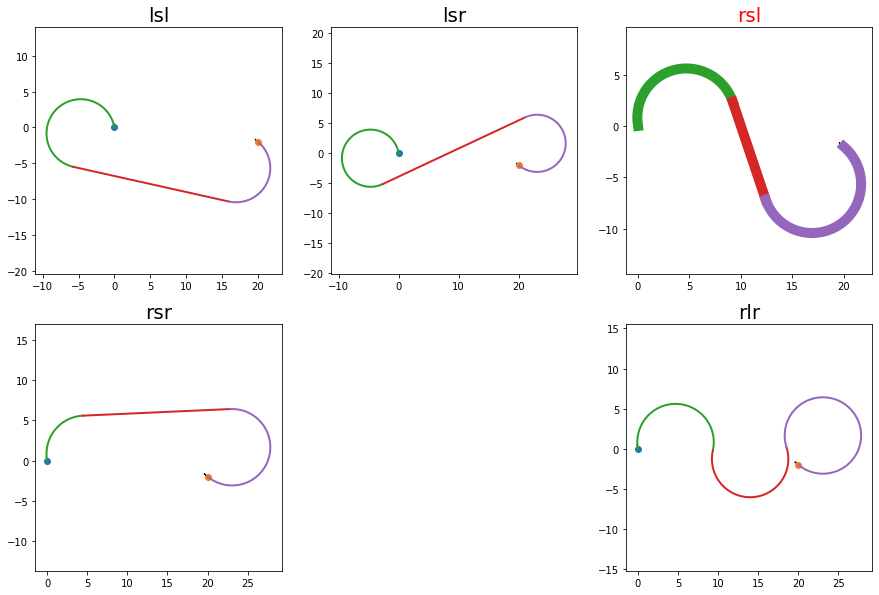

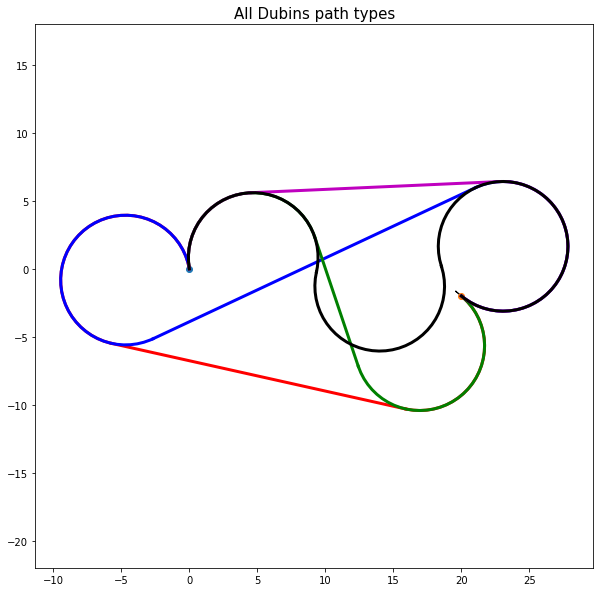

In [32]:
def test():
    plt.figure(figsize=(15,10))
    init_state = [0,0,100 * (np.pi/180)]
    goal_state = [20,-2,140 * (np.pi/180)]
    x_list, y_list = [], []
    dubins = DubinsPath(init_state, goal_state, r_turn)
    dubins.set_dubins_path()
    shortest_path, _ = dubins.get_shortest_path()
    print(shortest_path)

    for i in range(len(dubins.dubins_words)):
        path = dubins.path[i]
        color = "k"
        linewidth = 2
        if path == shortest_path:
            color = "r"
            linewidth = 10
        print("Dubins path : ", path)
        if path:
            plt.subplot(2,3,i+1)
            plt.title('{}{}{}'.format(path[0][0], path[1][0], path[2][0]), fontsize=20, color=color)
            dubins.draw_point(init_state)
            dubins.draw_point(goal_state)
            xs, ys = DubinsPath.gen_dubins_path(init_state, path, r_turn)
            for i in range(3):
                plt.plot(xs[i], ys[i], linewidth=linewidth)
            plt.axis('equal')

            x_list.append(xs)
            y_list.append(ys)
        
    color_set = ['r', 'b', 'g', 'm', 'k', 'c']
    plt.figure(figsize=(10,10))
    dubins.draw_point(init_state)
    dubins.draw_point(goal_state)
    plt.title("All Dubins path types", fontsize=15)
    plt.axis('equal')

    k = 0
    for i in range(len(dubins.dubins_words)):
        path = dubins.path[i]
        if path:
            for j in range(3):
                plt.plot(x_list[k][j], y_list[k][j], color_set[k], linewidth=3)
            k += 1
        
if __name__ == "__main__":
    test()
    